In [ ]:
 ! pip install -q kaggle

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras import optimizers, metrics, models
from keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout
from keras.utils.np_utils import to_categorical

In [ ]:
from google.colab import files

# Upload api key (kaggle.json)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mackycj","key":"46c83b963c3dccd29d721f5578e18fde"}'}

In [ ]:
!kaggle datasets download -d prasunroy/natural-images

 97% 333M/342M [00:01<00:00, 229MB/s]
100% 342M/342M [00:01<00:00, 240MB/s]


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d prasunroy/natural-images

natural-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

data  kaggle.json  natural_images  natural-images.zip  sample_data


In [ ]:
!unzip -q /content/natural-images.zip -d .

replace ./data/natural_images/airplane/airplane_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
dir = '/content/natural_images'

# Features and Labels
ft = []
lb = []
labels = {}

determine_label = ['car','flower','fruit','person'] # Interested classes 

r = 0

# Extracting label string and index
for i, k in enumerate(os.listdir(dir)):
    
    if k in determine_label:
        labels[k] = r
        r += 1

# Appending features and labels
for i in determine_label:
    subdir = os.path.join(dir, i)
    for j in tqdm(os.listdir(subdir)):
        im = cv2.imread(os.path.join(subdir, j), 0)
        im = cv2.resize(im, (70, 70))
        ft.append(im) 
        lb.append(labels[i])       

100%|██████████| 986/986 [00:00<00:00, 2029.69it/s]


In [ ]:
labels

{'car': 0, 'flower': 2, 'fruit': 3, 'person': 1}

In [ ]:
# Converting to numpy arrays
ft = np.array(ft)
lb = np.array(lb).reshape(len(ft), 1)

ft.shape, lb.shape

((3797, 70, 70), (3797, 1))

In [ ]:
# Reshaping features to add dimension for graychannel
X = ft.reshape(-1, 70, 70, 1)
X.shape

(3797, 70, 70, 1)

In [ ]:
# One Hot Encoding label values
Y = to_categorical(lb)
Y.shape

(3797, 4)

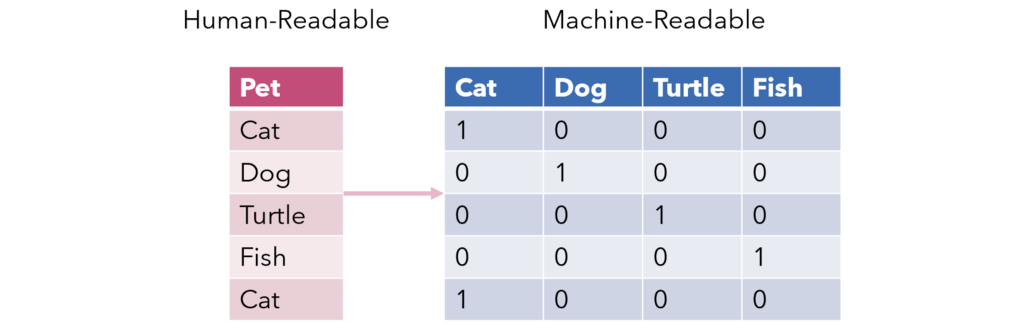

In [ ]:
# Normalizing feautures values
X = X/255.0

# Spliting into train and test 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2847, 70, 70, 1), (950, 70, 70, 1), (2847, 4), (950, 4))

In [ ]:
# Shape of one element of x_train
x_train.shape[1:]

(70, 70, 1)

In [ ]:
# Initializing the model instance
model = models.Sequential()

# Adding layers to model instance

model.add(Conv2D(32,(3,3) , padding='same' , input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3) , padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3) , padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(256,(3,3) , padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512,(3,3) , padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))


model.add(Conv2D(1024,(3,3) , padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(4,activation='softmax')) # 4 neurons for 4 classes

In [ ]:
# Checking model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 70, 70, 32)        320       
_________________________________________________________________
activation_12 (Activation)   (None, 70, 70, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 35, 35, 64)        18496     
_________________________________________________________________
activation_13 (Activation)   (None, 35, 35, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 17, 17, 64)       

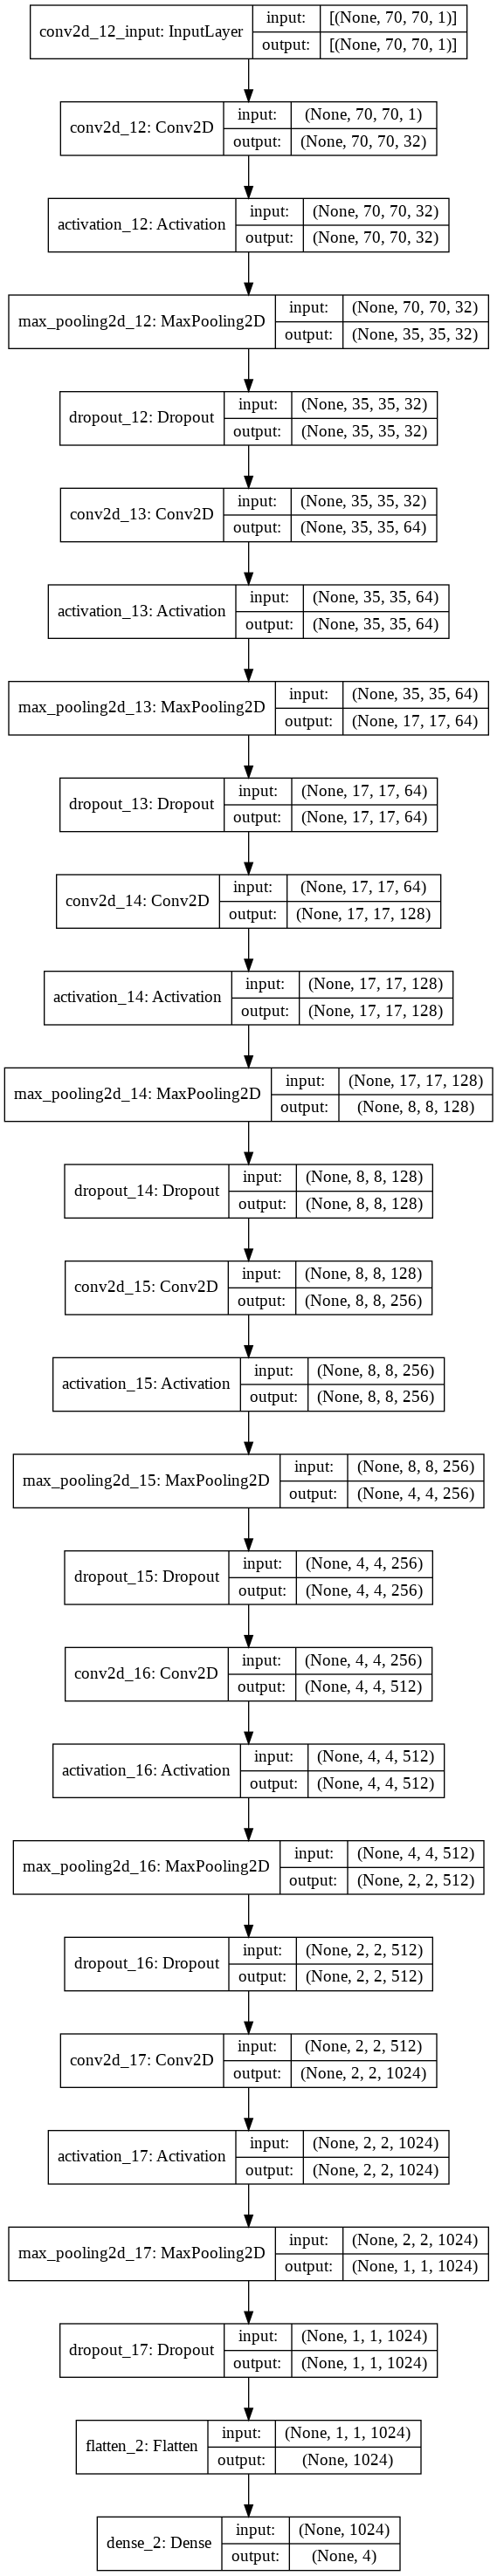

In [ ]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)

In [ ]:
# Compiling the model
model.compile(optimizer='sgd',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Importing a callback
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=5)

hist = model.fit(x_train, y_train, 
          epochs=180,
        callbacks=[early_stopping_monitor],
          validation_data=(x_test, y_test))

Epoch 1/180
89/89 [==============================] - 2s 21ms/step - loss: 1.3871 - accuracy: 0.2634 - val_loss: 1.3796 - val_accuracy: 0.2916
Epoch 2/180
89/89 [==============================] - 2s 18ms/step - loss: 1.3735 - accuracy: 0.2915 - val_loss: 1.3753 - val_accuracy: 0.2695
Epoch 3/180
89/89 [==============================] - 2s 18ms/step - loss: 1.3648 - accuracy: 0.3432 - val_loss: 1.3641 - val_accuracy: 0.2695
Epoch 4/180
89/89 [==============================] - 2s 18ms/step - loss: 1.3454 - accuracy: 0.3576 - val_loss: 1.3349 - val_accuracy: 0.3000
Epoch 5/180
89/89 [==============================] - 2s 18ms/step - loss: 1.2893 - accuracy: 0.4012 - val_loss: 1.2245 - val_accuracy: 0.5611
Epoch 6/180
89/89 [==============================] - 2s 18ms/step - loss: 1.1362 - accuracy: 0.4951 - val_loss: 1.0343 - val_accuracy: 0.6368
Epoch 7/180
89/89 [==============================] - 2s 18ms/step - loss: 1.0347 - accuracy: 0.5319 - val_loss: 0.9696 - val_accuracy: 0.6274
Epoch 

In [ ]:
print('Training Accuracy: {0:.2%}'.format(float(model.evaluate(x_train,y_train)[1])))
print('Testing Accuracy: {0:.2%}'.format(float(model.evaluate(x_test,y_test)[1])))

89/89 [==============================] - 1s 6ms/step - loss: 0.1676 - accuracy: 0.9417
Training Accuracy: 94.17%
30/30 [==============================] - 0s 6ms/step - loss: 0.1863 - accuracy: 0.9421
Testing Accuracy: 94.21%


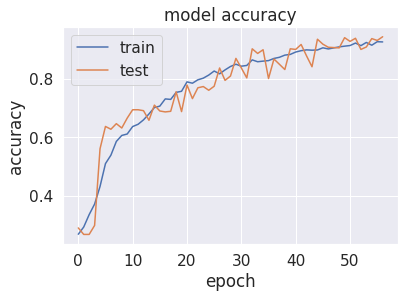

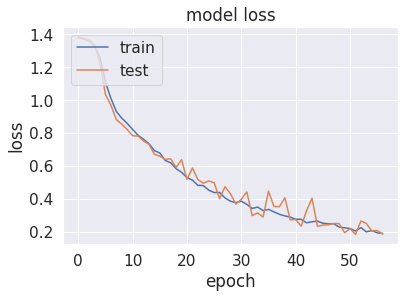

In [ ]:
# Summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model accuracy.png')
plt.show()
# Summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model loss.png')
plt.show()

In [ ]:
# List with label names
rev_labels = []

for i, k in enumerate(labels.keys()):
    rev_labels.append(k)

rev_labels

['car', 'person', 'flower', 'fruit']

Image number :  336
flower


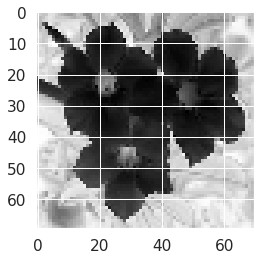

------------------------------------
Image number :  777
car


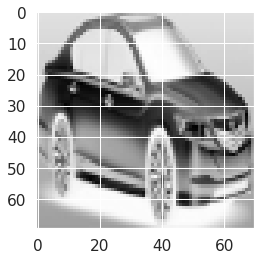

------------------------------------
Image number :  109
car


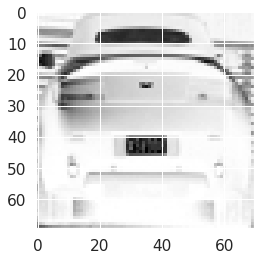

------------------------------------
Image number :  193
car


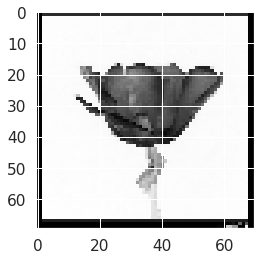

------------------------------------
Image number :  549
car


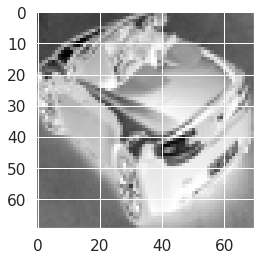

------------------------------------


In [ ]:
# Prediction
import random
def predict(i):
    pre_img = i
    print('Image number : ',pre_img)

    print(rev_labels[np.argmax(model.predict([x_test[pre_img:pre_img+1]]))])
    plt.imshow(x_test[pre_img:pre_img+1].reshape(70,70), cmap='binary')
    plt.show()
    print('------------------------------------')

for i in range(5):
    predict(i+random.randint(0,x_test.shape[0]))

In [ ]:
labels

{'car': 0, 'flower': 2, 'fruit': 3, 'person': 1}

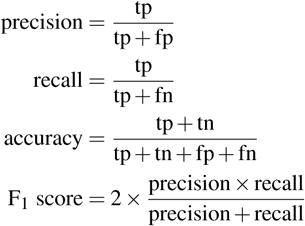

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

y_pred = model.predict_classes(x_test)

y_testing = np.argmax(y_test, axis = 1)

print(classification_report(y_testing, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.91      0.97      0.94       237
           1       0.91      1.00      0.95       256
           2       0.97      0.77      0.86       203
           3       1.00      1.00      1.00       254

    accuracy                           0.94       950
   macro avg       0.95      0.93      0.94       950
weighted avg       0.94      0.94      0.94       950



In [ ]:
cf_matrix = confusion_matrix(y_testing, y_pred)

In [ ]:
cf_matrix

array([[229,   4,   4,   0],
       [  0, 255,   1,   0],
       [ 23,  22, 157,   1],
       [  0,   0,   0, 254]])

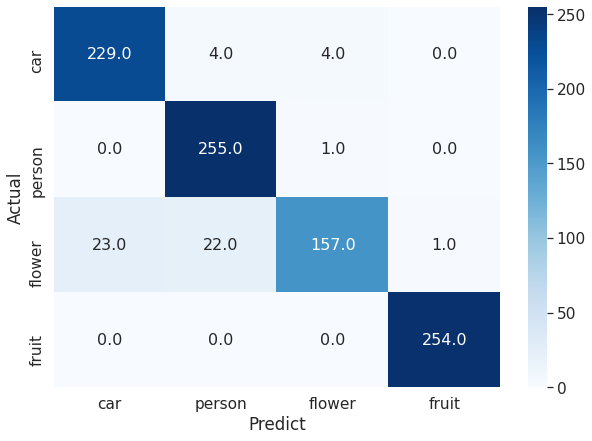

In [ ]:
import pandas as pd
import seaborn as sn


df_cm = pd.DataFrame(cf_matrix, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predict'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt=".1f")# font size

# **Reference**


---

Image Data Set 

*   https://www.kaggle.com/prasunroy/natural-images


Code Ref

*   https://www.kaggle.com/err0r90/natural-images-with-cnn
